In [37]:
import warnings
warnings.filterwarnings('ignore')

In [38]:
import jetset
print('tested on jetset',jetset.__version__)

tested on jetset 1.2.0rc4


# Depending parameters

## example: depending pars for bkn power-law emitters

In [40]:
from jetset.jet_emitters import EmittersDistribution
import numpy as np



from jetset.jet_model import Jet

j = Jet(emitters_distribution='bkn')


j.parameters


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,5.000000e+15,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,1.000000e-01,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,1.000000e+01,1.000000e-04,--,False,False
jet_leptonic,z_cosm,redshift,,1.000000e-01,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,2.000000e+00,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.000000e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,1.000000e+02,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,1.000000e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p,LE_spectral_slope,,2.500000e+00,-1.000000e+01,1.000000e+01,False,False


None

In [41]:
j.make_dependent_par(par='p_1',depends_on=['p'],par_expr='1 + p')
j.parameters.p.val=2
np.testing.assert_allclose(j.parameters.p_1.val, j.parameters.p.val + 1)
j.parameters

==> par p_1 is now depending on ['p'] according to expr 1 + p


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,5.000000e+15,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,1.000000e-01,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,1.000000e+01,1.000000e-04,--,False,False
jet_leptonic,z_cosm,redshift,,1.000000e-01,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,2.000000e+00,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.000000e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,1.000000e+02,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,1.000000e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p(M),LE_spectral_slope,,2.000000e+00,-1.000000e+01,1.000000e+01,False,False


None

In [42]:
j.save_model('jet.pkl')
new_jet=Jet.load_model('jet.pkl')


==> par p_1 is now depending on ['p'] according to expr 1 + p


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,2.000000e+00,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.000000e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,1.000000e+02,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,1.000000e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p(M),LE_spectral_slope,,2.000000e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,"*p_1(D,p)",HE_spectral_slope,,3.000000e+00,-1.000000e+01,1.000000e+01,False,True
jet_leptonic,R,region_size,cm,5.000000e+15,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,1.000000e-01,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,1.000000e+01,1.000000e-04,--,False,False


In [43]:
new_jet.parameters.p.val=2.5
np.testing.assert_allclose(new_jet.parameters.p_1.val, new_jet.parameters.p.val + 1)
new_jet.parameters

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,2.000000e+00,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.000000e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,1.000000e+02,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,1.000000e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p(M),LE_spectral_slope,,2.500000e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,"*p_1(D,p)",HE_spectral_slope,,3.500000e+00,-1.000000e+01,1.000000e+01,False,True
jet_leptonic,R,region_size,cm,5.000000e+15,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,1.000000e-01,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,1.000000e+01,1.000000e-04,--,False,False


None

## example: linked paramters for EBL

In [44]:
from jetset.jet_model import Jet
from jetset.template_2Dmodel import EBLAbsorptionTemplate
from jetset.model_manager import FitModel

my_jet = Jet(electron_distribution='lppl', name='jet_flaring')
my_jet.parameters.z_cosm.val = 0.01

ebl_franceschini = EBLAbsorptionTemplate.from_name('Franceschini_2008')

composite_model = FitModel(nu_size=500, name='EBL corrected')
composite_model.add_component(my_jet)
composite_model.add_component(ebl_franceschini)

composite_model.show_pars()

composite_model.link_par(par_name='z_cosm', from_model='Franceschini_2008', to_model='jet_flaring')
v=0.03001
my_jet.parameters.z_cosm.val = v
assert (composite_model.Franceschini_2008.parameters.z_cosm.val==v)
assert (composite_model.Franceschini_2008.parameters.z_cosm.linked==True)

composite_model.composite_expr = '%s*%s'%(my_jet.name,ebl_franceschini.name)
composite_model.eval()

#if plot is True:
#    composite_model.plot_model()

composite_model.save_model('ebl_jet.pkl')
new_composite_model=FitModel.load_model('ebl_jet.pkl')
new_composite_model.show_pars()
v=2.0
new_composite_model.jet_flaring.parameters.z_cosm.val=v
print(new_composite_model.Franceschini_2008.parameters.z_cosm.val,v)
assert (new_composite_model.Franceschini_2008.parameters.z_cosm.val == v)
assert (new_composite_model.Franceschini_2008.parameters.z_cosm.linked == True)

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_flaring,R,region_size,cm,5.000000e+15,1.000000e+03,1.000000e+30,False,False
jet_flaring,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_flaring,B,magnetic_field,gauss,1.000000e-01,0.000000e+00,--,False,False
jet_flaring,beam_obj,beaming,lorentz-factor*,1.000000e+01,1.000000e-04,--,False,False
jet_flaring,z_cosm,redshift,,1.000000e-02,0.000000e+00,--,False,False
jet_flaring,gmin,low-energy-cut-off,lorentz-factor*,2.000000e+00,1.000000e+00,1.000000e+09,False,False
jet_flaring,gmax,high-energy-cut-off,lorentz-factor*,1.000000e+06,1.000000e+00,1.000000e+15,False,False
jet_flaring,N,emitters_density,1 / cm3,1.000000e+02,0.000000e+00,--,False,False
jet_flaring,gamma0_log_parab,turn-over-energy,lorentz-factor*,1.000000e+04,1.000000e+00,1.000000e+09,False,False
jet_flaring,s,LE_spectral_slope,,2.000000e+00,-1.000000e+01,1.000000e+01,False,False


==> par: z_cosm from model: Franceschini_2008 linked to same parameter in model jet_flaring
==> par: z_cosm from model: Franceschini_2008 linked to same parameter in model jet_flaring


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_flaring,gmin,low-energy-cut-off,lorentz-factor*,2.000000e+00,1.000000e+00,1.000000e+09,False,False
jet_flaring,gmax,high-energy-cut-off,lorentz-factor*,1.000000e+06,1.000000e+00,1.000000e+15,False,False
jet_flaring,N,emitters_density,1 / cm3,1.000000e+02,0.000000e+00,--,False,False
jet_flaring,gamma0_log_parab,turn-over-energy,lorentz-factor*,1.000000e+04,1.000000e+00,1.000000e+09,False,False
jet_flaring,s,LE_spectral_slope,,2.000000e+00,-1.000000e+01,1.000000e+01,False,False
jet_flaring,r,spectral_curvature,,4.000000e-01,-1.500000e+01,1.500000e+01,False,False
jet_flaring,R,region_size,cm,5.000000e+15,1.000000e+03,1.000000e+30,False,False
jet_flaring,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_flaring,B,magnetic_field,gauss,1.000000e-01,0.000000e+00,--,False,False
jet_flaring,beam_obj,beaming,lorentz-factor*,1.000000e+01,1.000000e-04,--,False,False


2.0 2.0


## example depending par: Building a Jet model with B function of R_H and R_0

In [46]:
jet=Jet(emitters_distribution='plc')
fit_model_lsb=FitModel( jet=jet, name='SSC-best-fit-lsb',template=None)
fit_model_lsb.jet_leptonic.parameters.beam_obj.fit_range = [5, 50]
fit_model_lsb.jet_leptonic.parameters.R_H.val=5E17
fit_model_lsb.jet_leptonic.parameters.R_H.frozen=False
fit_model_lsb.jet_leptonic.parameters.R_H.fit_range = [1E15, 1E19]
fit_model_lsb.jet_leptonic.parameters.R.fit_range = [10 ** 15.5, 10 ** 17.5]

fit_model_lsb.jet_leptonic.add_user_par(name='B0',units='G',val=1E3,val_min=0,val_max=None)
fit_model_lsb.jet_leptonic.add_user_par(name='R0', units='cm', val=5E13, val_min=0, val_max=None)
fit_model_lsb.jet_leptonic.parameters.R0.frozen=True
fit_model_lsb.jet_leptonic.parameters.B0.frozen=True

par_expr = 'B0*np.power((R0/R_H),1.1)'

fit_model_lsb.jet_leptonic.make_dependent_par(par='B', depends_on=['B0', 'R0', 'R_H'], par_expr=par_expr)

B0=fit_model_lsb.jet_leptonic.parameters.B0.val
R0 = fit_model_lsb.jet_leptonic.parameters.R0.val
R_H = fit_model_lsb.jet_leptonic.parameters.R_H.val

np.testing.assert_allclose(fit_model_lsb.jet_leptonic.parameters.B.val, eval(par_expr))

==> par B is now depending on ['B0', 'R0', 'R_H'] according to expr B0*np.power((R0/R_H),1.1)


In [47]:
fit_model_lsb.jet_leptonic.parameters

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,5.000000e+15,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H(M),region_position,cm,5.000000e+17,0.000000e+00,--,False,False
jet_leptonic,"*B(D,R_H)",magnetic_field,gauss,3.981072e-02,0.000000e+00,--,False,True
jet_leptonic,beam_obj,beaming,lorentz-factor*,1.000000e+01,1.000000e-04,--,False,False
jet_leptonic,z_cosm,redshift,,1.000000e-01,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,2.000000e+00,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.000000e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,1.000000e+02,0.000000e+00,--,False,False
jet_leptonic,gamma_cut,turn-over-energy,lorentz-factor*,1.000000e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p,LE_spectral_slope,,2.000000e+00,-1.000000e+01,1.000000e+01,False,False


None

In [48]:
fit_model_lsb.jet_leptonic.parameters

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,5.000000e+15,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H(M),region_position,cm,5.000000e+17,0.000000e+00,--,False,False
jet_leptonic,"*B(D,R_H)",magnetic_field,gauss,3.981072e-02,0.000000e+00,--,False,True
jet_leptonic,beam_obj,beaming,lorentz-factor*,1.000000e+01,1.000000e-04,--,False,False
jet_leptonic,z_cosm,redshift,,1.000000e-01,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,2.000000e+00,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.000000e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,1.000000e+02,0.000000e+00,--,False,False
jet_leptonic,gamma_cut,turn-over-energy,lorentz-factor*,1.000000e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p,LE_spectral_slope,,2.000000e+00,-1.000000e+01,1.000000e+01,False,False


None

In [49]:
fit_model_lsb.save_model('test.pkl')

In [50]:
fit_model_lsb=FitModel.load_model('test.pkl')

==> par B is now depending on ['B0', 'R0', 'R_H'] according to expr B0*np.power((R0/R_H),1.1)


## example depending par: fitting with a Jet model with depending pars


In [51]:
from jetset.test_data_helper import  test_SEDs
from jetset.data_loader import ObsData,Data
from jetset.plot_sedfit import PlotSED
from jetset.test_data_helper import  test_SEDs

In [52]:
data=Data.from_file(test_SEDs[1])


***  binning data  ***
---> N bins= 89
---> bin_widht= 0.2



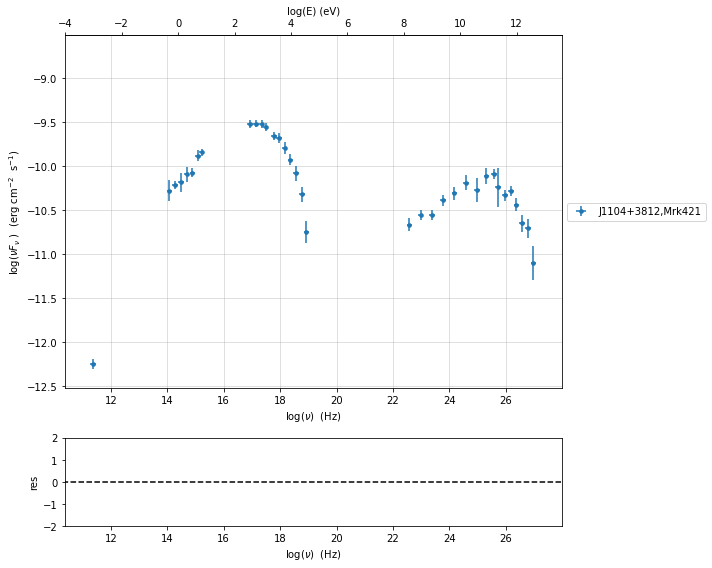

In [53]:
sed_data=ObsData(data_table=data)
sed_data.group_data(bin_width=0.2)

sed_data.add_systematics(0.1,[10.**6,10.**29])
p=sed_data.plot_sed()


*** evaluating spectral indices for data ***



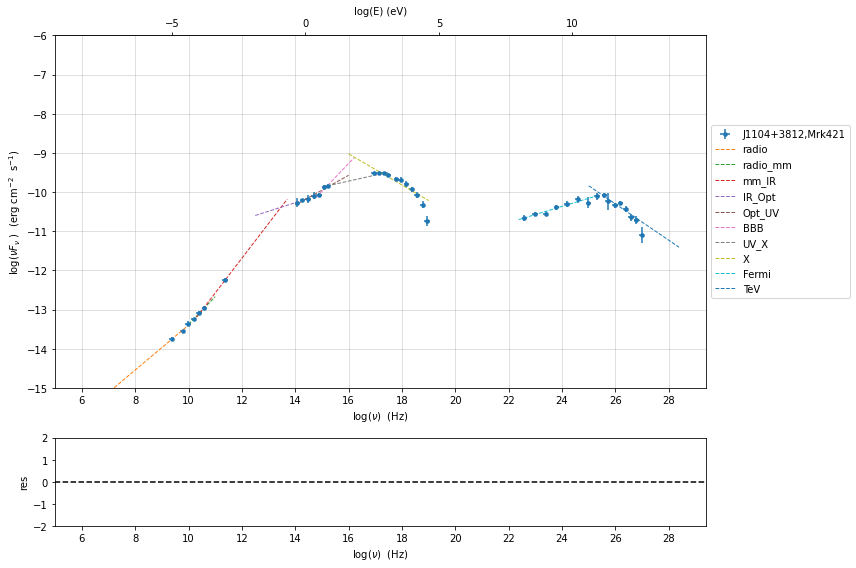

In [54]:
from jetset.sed_shaper import  SEDShape
my_shape=SEDShape(sed_data)
my_shape.eval_indices(minimizer='lsb',silent=True)
p=my_shape.plot_indices()
p.rescale(y_min=-15,y_max=-6)

In [55]:
mm,best_fit=my_shape.sync_fit(check_host_gal_template=False,
                  Ep_start=None,
                  minimizer='lsb',
                  silent=True,
                  fit_range=[10.,21.])


*** Log-Polynomial fitting of the synchrotron component ***
---> first blind fit run,  fit range: [10.0, 21.0]
---> class:  HSP





model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
LogCubic,b,-1.545300e-01,-1.545300e-01,9.534795e-03,--,-1.000000e+00,-1.000000e+01,0.000000e+00,False
LogCubic,c,-1.023245e-02,-1.023245e-02,1.433073e-03,--,-1.000000e+00,-1.000000e+01,1.000000e+01,False
LogCubic,Ep,1.672267e+01,1.672267e+01,4.139942e-02,--,1.667039e+01,0.000000e+00,3.000000e+01,False
LogCubic,Sp,-9.491659e+00,-9.491659e+00,2.515285e-02,--,-1.000000e+01,-3.000000e+01,0.000000e+00,False


---> sync       nu_p=+1.672267e+01 (err=+4.139942e-02)  nuFnu_p=-9.491659e+00 (err=+2.515285e-02) curv.=-1.545300e-01 (err=+9.534795e-03)




*** Log-Polynomial fitting of the IC component ***
---> fit range: [23.0, 29.0]
---> LogCubic fit




model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
LogCubic,b,-2.098186e-01,-2.098186e-01,3.133100e-02,--,-1.000000e+00,-1.000000e+01,0.000000e+00,False
LogCubic,c,-4.661867e-02,-4.661867e-02,2.178435e-02,--,-1.000000e+00,-1.000000e+01,1.000000e+01,False
LogCubic,Ep,2.524926e+01,2.524926e+01,1.147802e-01,--,2.529412e+01,0.000000e+00,3.000000e+01,False
LogCubic,Sp,-1.011085e+01,-1.011085e+01,3.498963e-02,--,-1.000000e+01,-3.000000e+01,0.000000e+00,False


---> IC         nu_p=+2.524926e+01 (err=+1.147802e-01)  nuFnu_p=-1.011085e+01 (err=+3.498963e-02) curv.=-2.098186e-01 (err=+3.133100e-02)



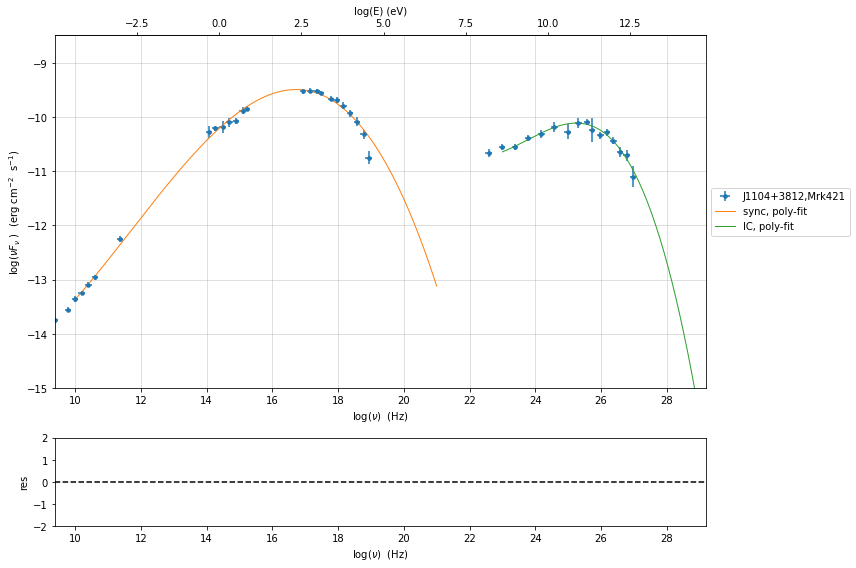

In [56]:
my_shape.IC_fit(fit_range=[23.,29.],minimizer='minuit',silent=True)
p=my_shape.plot_shape_fit()
p.rescale(y_min=-15)

In [57]:
from jetset.obs_constrain import ObsConstrain
from jetset.model_manager import  FitModel
sed_obspar=ObsConstrain(beaming=25,
                        B_range=[0.001,0.1],
                        distr_e='lppl',
                        t_var_sec=3*86400,
                        nu_cut_IR=1E12,
                        SEDShape=my_shape)


prefit_jet=sed_obspar.constrain_SSC_model(electron_distribution_log_values=False,silent=True)
prefit_jet.save_model('prefit_jet.pkl')


***  constrains parameters from observable ***



model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,3.117075e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False
jet_leptonic,z_cosm,redshift,,3.080000e-02,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,4.697542e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.373160e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,9.048159e-01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,3.188500e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.181578e+00,-1.000000e+01,1.000000e+01,False,False


In [58]:
from jetset.minimizer import fit_SED,ModelMinimizer

from jetset.model_manager import  FitModel
from jetset.jet_model import Jet

In [59]:
fit_model_lsb=FitModel( jet=prefit_jet, name='SSC-best-fit-lsb',template=None)
fit_model_lsb.parameters

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,3.117075e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False
jet_leptonic,z_cosm,redshift,,3.080000e-02,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,4.697542e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.373160e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,9.048159e-01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,3.188500e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.181578e+00,-1.000000e+01,1.000000e+01,False,False


None

In [60]:
fit_model_lsb.jet_leptonic.parameters.beam_obj.fit_range = [5, 50]
fit_model_lsb.jet_leptonic.parameters.R_H.val=5E17
fit_model_lsb.jet_leptonic.parameters.R_H.frozen=False
fit_model_lsb.jet_leptonic.parameters.R_H.fit_range = [1E15, 1E19]
fit_model_lsb.jet_leptonic.parameters.R.fit_range = [10 ** 15.5, 10 ** 17.5]
fit_model_lsb.jet_leptonic.add_user_par(name='B0',units='G',val=1E3,val_min=0,val_max=None)
fit_model_lsb.jet_leptonic.add_user_par(name='R0', units='cm', val=5E13, val_min=0, val_max=None)
fit_model_lsb.jet_leptonic.parameters.R0.frozen=True
fit_model_lsb.jet_leptonic.parameters.B0.frozen=True

fit_model_lsb.jet_leptonic.make_dependent_par(par='B',depends_on=['B0','R0','R_H'],par_expr='B0*(R0/R_H)')
fit_model_lsb.parameters

==> par B is now depending on ['B0', 'R0', 'R_H'] according to expr B0*(R0/R_H)


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,3.117075e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H(M),region_position,cm,5.000000e+17,0.000000e+00,--,False,False
jet_leptonic,"*B(D,R_H)",magnetic_field,gauss,1.000000e-01,0.000000e+00,--,False,True
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False
jet_leptonic,z_cosm,redshift,,3.080000e-02,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,4.697542e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.373160e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,9.048159e-01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,3.188500e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.181578e+00,-1.000000e+01,1.000000e+01,False,False


None

Text(0, 0.5, 'B (G)')

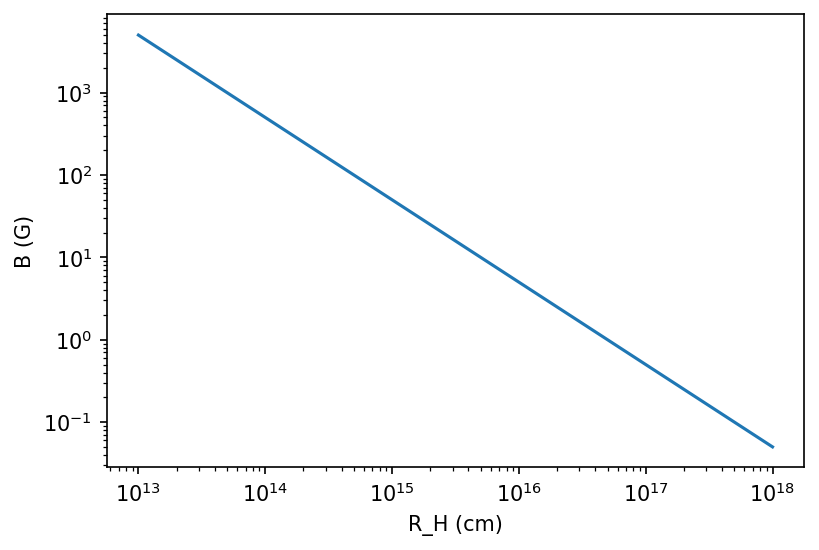

In [61]:
%matplotlib inline
plt.figure(dpi=150)
R_H_array=np.logspace(13,18,100)
B_array=np.zeros(R_H_array.shape)
for ID,R_H in enumerate(R_H_array):
    fit_model_lsb.jet_leptonic.parameters.R_H.val=R_H
    B_array[ID]=fit_model_lsb.jet_leptonic.parameters.B.val

plt.loglog(R_H_array,B_array)
plt.xlabel('R_H (cm)')
plt.ylabel('B (G)')

In [62]:
fit_model_lsb.jet_leptonic.parameters.R_H.val=5E17

In [63]:
fit_model_lsb.parameters

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,3.117075e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H(M),region_position,cm,5.000000e+17,0.000000e+00,--,False,False
jet_leptonic,"*B(D,R_H)",magnetic_field,gauss,1.000000e-01,0.000000e+00,--,False,True
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False
jet_leptonic,z_cosm,redshift,,3.080000e-02,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,4.697542e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.373160e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,9.048159e-01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,3.188500e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.181578e+00,-1.000000e+01,1.000000e+01,False,False


None

In [64]:
model_minimizer_lsb=ModelMinimizer('lsb')


In [65]:
best_fit_lsb=model_minimizer_lsb.fit(fit_model_lsb,
                                     sed_data,
                                     1E11,
                                     1E29,
                                     fitname='SSC-best-fit-minuit',
                                     repeat=3)

filtering data in fit range = [1.000000e+11,1.000000e+29]
data length 35

*** start fit process ***
----- 
fit run: 0


0it [00:00, ?it/s]


- best chisq=4.61764e+01
fit run: 1
- old chisq=4.61764e+01


0it [00:00, ?it/s]


- best chisq=4.46880e+01
fit run: 2
- old chisq=4.46880e+01


0it [00:00, ?it/s]


- best chisq=4.46880e+01
-------------------------------------------------------------------------
Fit report

Model: SSC-best-fit-minuit


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,3.017734e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H(M),region_position,cm,1.159858e+18,0.000000e+00,--,False,False
jet_leptonic,"*B(D,R_H)",magnetic_field,gauss,4.310872e-02,0.000000e+00,--,False,True
jet_leptonic,beam_obj,beaming,lorentz-factor*,4.231090e+01,1.000000e-04,--,False,False
jet_leptonic,z_cosm,redshift,,7.156064e-02,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,4.763953e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,7.382877e+05,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,1.137528e+00,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,4.095750e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.286343e+00,-1.000000e+01,1.000000e+01,False,False



converged=True
calls=22
mesg=


'The relative error between two consecutive iterates is at most 0.000000'

dof=25
chisq=44.688023, chisq/red=1.787521 null hypothesis sig=0.009074

best fit pars


model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
jet_leptonic,R,3.017734e+16,3.017734e+16,3.955169e+17,--,3.117075e+16,3.162278e+15,3.162278e+17,False
jet_leptonic,R_H(M),1.159858e+18,1.159858e+18,1.648745e+18,--,5.000000e+17,1.000000e+15,1.000000e+19,False
jet_leptonic,"*B(D,R_H)",4.310872e-02,--,--,--,1.000000e-01,0.000000e+00,--,True
jet_leptonic,beam_obj,4.231090e+01,4.231090e+01,5.348247e+01,--,2.500000e+01,5.000000e+00,5.000000e+01,False
jet_leptonic,z_cosm,7.156064e-02,7.156064e-02,8.812778e-01,--,3.080000e-02,0.000000e+00,--,False
jet_leptonic,gmin,4.763953e+02,4.763953e+02,7.669914e+02,--,4.697542e+02,1.000000e+00,1.000000e+09,False
jet_leptonic,gmax,7.382877e+05,7.382877e+05,9.969415e+05,--,1.373160e+06,1.000000e+00,1.000000e+15,False
jet_leptonic,N,1.137528e+00,1.137528e+00,1.671422e+01,--,9.048159e-01,0.000000e+00,--,False
jet_leptonic,gamma0_log_parab,4.095750e+04,4.095750e+04,6.954578e+04,--,3.188500e+04,1.000000e+00,1.000000e+09,False
jet_leptonic,s,2.286343e+00,2.286343e+00,1.461970e-01,--,2.181578e+00,-1.000000e+01,1.000000e+01,False


-------------------------------------------------------------------------




In [29]:
fit_model_lsb.jet_leptonic.parameters.B._depending_par_expr

'B0*(R0/R_H)'

In [30]:
fit_model_lsb.save_model('test.pkl')


In [31]:
from jetset.model_manager import  FitModel

new_fit_model_lsb=FitModel.load_model('test.pkl')

==> par B is now depending on ['B0', 'R0', 'R_H'] according to expr B0*(R0/R_H)


In [32]:
new_fit_model_lsb.parameters

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,4.763953e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,7.382877e+05,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,1.137528e+00,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,4.095750e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.286343e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,7.291923e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,3.017734e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H(M),region_position,cm,1.159858e+18,0.000000e+00,--,False,False
jet_leptonic,"*B(D,R_H)",magnetic_field,gauss,4.310872e-02,0.000000e+00,--,False,True
jet_leptonic,beam_obj,beaming,lorentz-factor*,4.231090e+01,1.000000e-04,--,False,False


None

In [33]:
new_fit_model_lsb.jet_leptonic.parameters.reset_dependencies()

In [34]:
new_fit_model_lsb.parameters

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,4.763953e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,7.382877e+05,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,1.137528e+00,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,4.095750e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.286343e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,7.291923e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,3.017734e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.159858e+18,0.000000e+00,--,False,False
jet_leptonic,B,magnetic_field,gauss,4.310872e-02,0.000000e+00,--,False,True
jet_leptonic,beam_obj,beaming,lorentz-factor*,4.231090e+01,1.000000e-04,--,False,False


None

In [35]:
new_fit_model_lsb.jet_leptonic.make_dependent_par(par='B',depends_on=['B0','R0','R_H'],par_expr='B0*(R0/R_H)**1.2')


==> par B is now depending on ['B0', 'R0', 'R_H'] according to expr B0*(R0/R_H)**1.2


In [36]:
new_fit_model_lsb.parameters

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,4.763953e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,7.382877e+05,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,1.137528e+00,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,4.095750e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.286343e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,7.291923e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,3.017734e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H(M),region_position,cm,1.159858e+18,0.000000e+00,--,False,False
jet_leptonic,"*B(D,R_H)",magnetic_field,gauss,5.774019e-03,0.000000e+00,--,False,True
jet_leptonic,beam_obj,beaming,lorentz-factor*,4.231090e+01,1.000000e-04,--,False,False


None